In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from windrose import WindroseAxes
import seaborn as sns
import os

In [2]:
df = pd.read_csv('data/togo-dapaong_qc.csv')

In [3]:
summary_stats = df.describe()
missing_values = df.isna().sum()
null_thresh = len(df) * 0.05
cols_gt_5pct_nulls = missing_values[missing_values > null_thresh]

print("Summary Statistics")
display(summary_stats)

print("Missing Values Count")
display(missing_values)

print("Columns >5% Nulls")
display(cols_gt_5pct_nulls)


Summary Statistics


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,230.555040,151.258469,116.444352,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330,NaN
std,322.532347,250.956962,156.520714,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277,NaN
min,-12.700000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000,NaN
25%,-2.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000,NaN
50%,2.100000,0.000000,2.500000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000,NaN
75%,442.400000,246.400000,215.700000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000,NaN
max,1424.000000,1004.500000,805.700000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000,NaN


Missing Values Count


Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Columns >5% Nulls


Comments    525600
dtype: int64

In [4]:
columns_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[columns_to_check].apply(zscore)

# Flag outliers with |Z| > 3
outliers = (z_scores.abs() > 3)
print("Outlier counts per column (|Z| > 3):")
display(outliers.sum())  # Number of outliers per column

# Mark rows that contain any outliers
df['OutlierFlag'] = outliers.any(axis=1)
print(f"Total rows flagged as outliers: {df['OutlierFlag'].sum()} out of {len(df)}")


Outlier counts per column (|Z| > 3):


GHI        305
DNI       1062
DHI       3415
ModA       137
ModB       206
WS        3510
WSgust    3915
dtype: int64

Total rows flagged as outliers: 9251 out of 525600


In [5]:
# Impute with median for key columns
df[columns_to_check] = df[columns_to_check].fillna(df[columns_to_check].median())

In [6]:
os.makedirs("data", exist_ok=True)
df.to_csv("data/cleaned/togo_clean.csv", index=False)

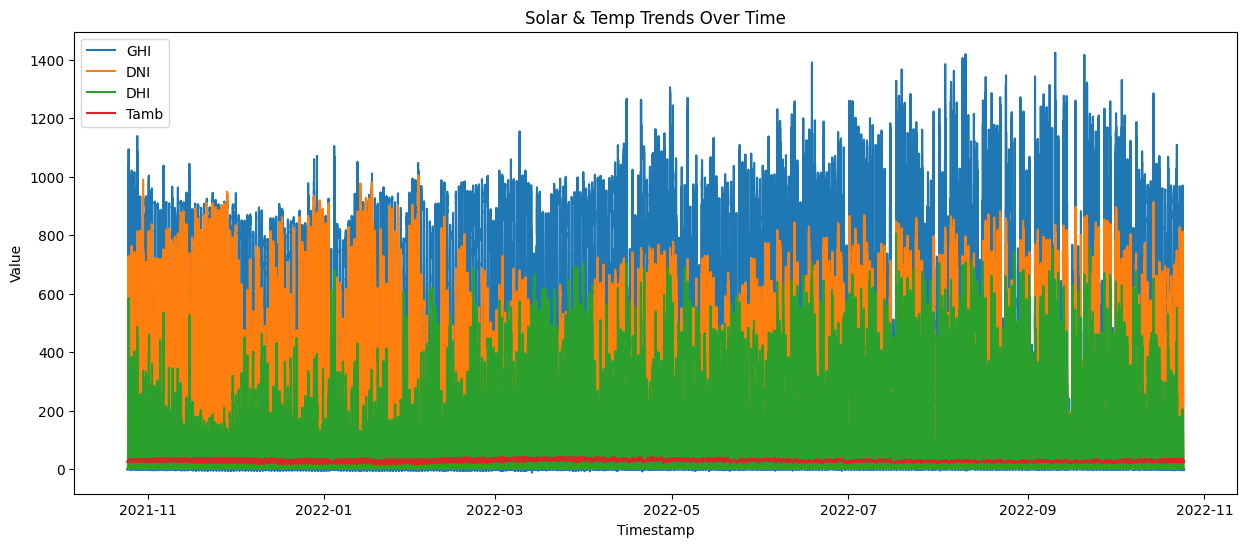

In [7]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Plot GHI, DNI, DHI, Tamb
plt.figure(figsize=(15, 6))
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(df['Timestamp'], df[col], label=col)
plt.legend()
plt.title("Solar & Temp Trends Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.show()


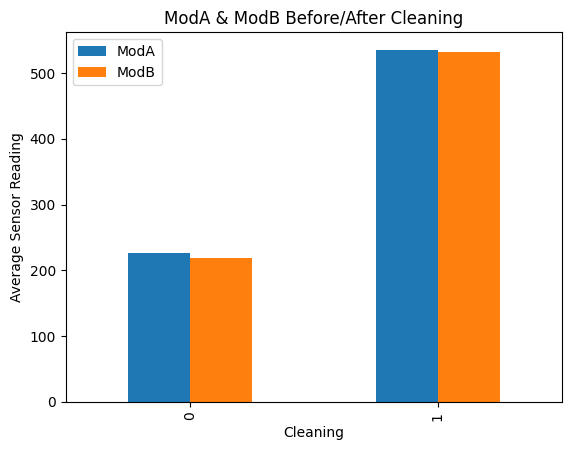

In [8]:
df['Cleaning'] = df['Cleaning'].astype(str)

# Group and plot average ModA & ModB
df.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar', title='ModA & ModB Before/After Cleaning')
plt.ylabel("Average Sensor Reading")
plt.show()


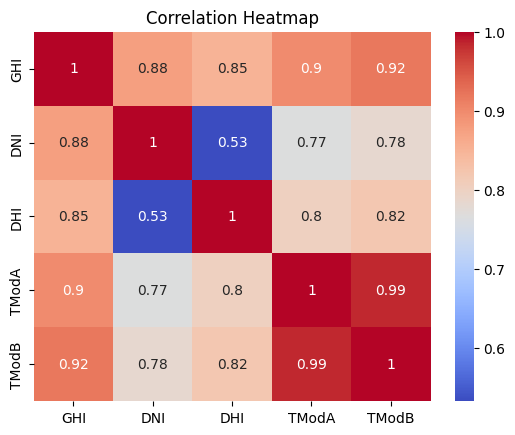

In [9]:
sns.heatmap(df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


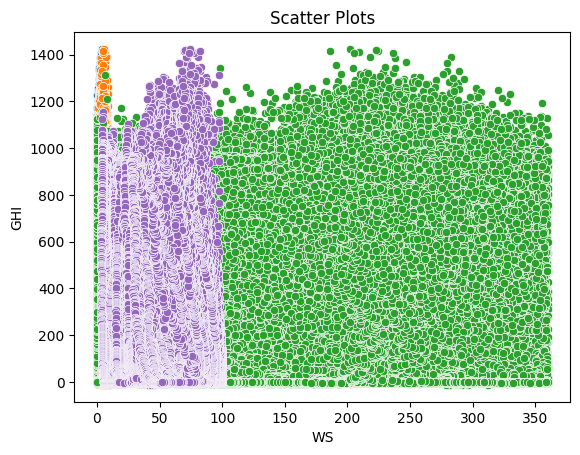

In [10]:
sns.scatterplot(x='WS', y='GHI', data=df)
sns.scatterplot(x='WSgust', y='GHI', data=df)
sns.scatterplot(x='WD', y='GHI', data=df)
sns.scatterplot(x='RH', y='Tamb', data=df)
sns.scatterplot(x='RH', y='GHI', data=df)
plt.title("Scatter Plots")
plt.show()


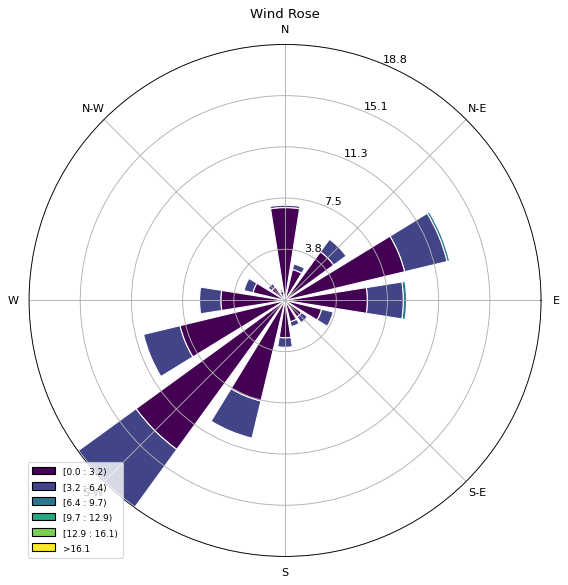

In [11]:
ax = WindroseAxes.from_ax()
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title("Wind Rose")
plt.show()


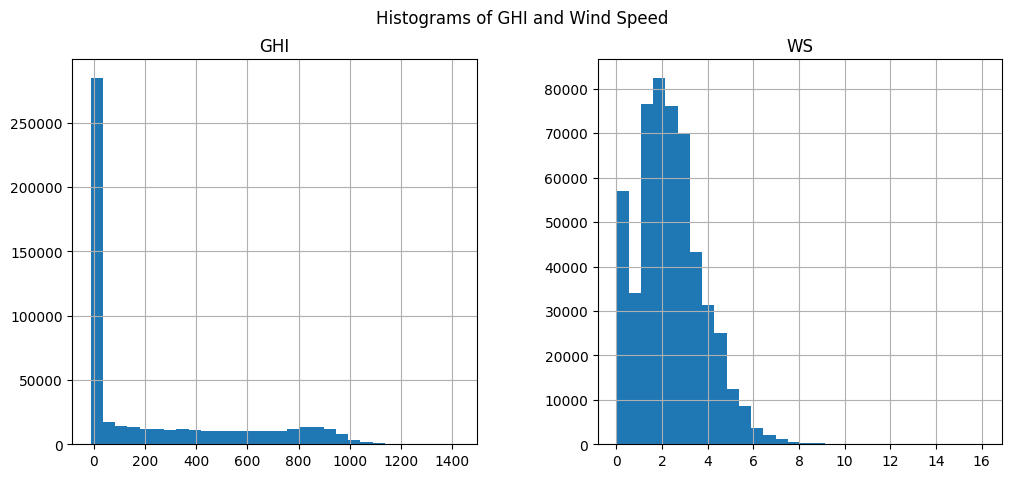

In [12]:
df[['GHI', 'WS']].hist(bins=30, figsize=(12, 5))
plt.suptitle("Histograms of GHI and Wind Speed")
plt.show()


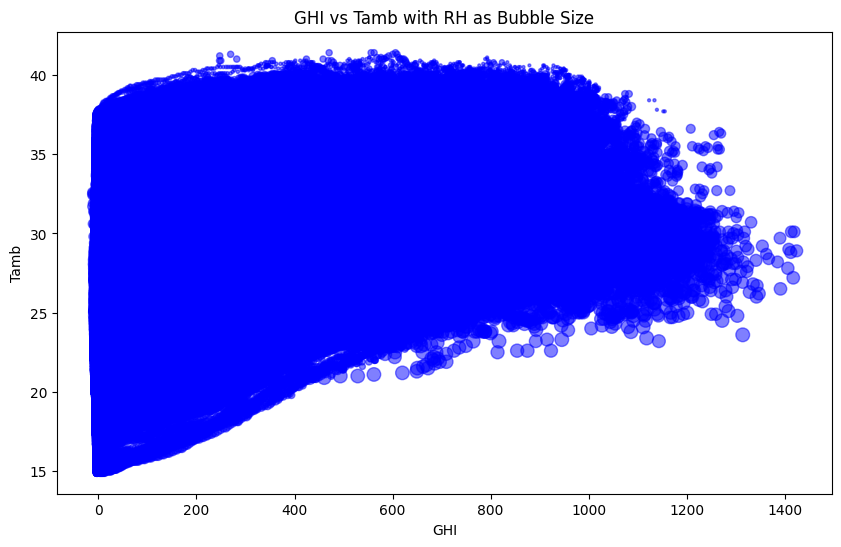

In [13]:
# Bubble Chart
plt.figure(figsize=(10, 6))
plt.scatter(df['GHI'], df['Tamb'], s=df['RH'], alpha=0.5, c='blue')
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title('GHI vs Tamb with RH as Bubble Size')
plt.show()
